In [161]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root, fsolve
import matplotlib.pyplot as plt
from distillation import antoineEthanolWater, wilsonActFact, enthalpy, enthalpyEthanolWater
from integrate_ketn01 import solve_ivp_mass


#FRÅGOR: Massmatrisen, Columngrafen

In [162]:
def ActFactEquil(x,Tguess,P):
    T = fsolve(lambda T: ActFactRes(x,T,P), Tguess)
    [y,y2] = ActFact(x,T,P)
    return y,T

#def ActFactEquil(x,Tguess,P):
#    sol = root(lambda T: ActFactRes(x,T,P), Tguess, method='hybr')
#    T = sol['x']
#    [y,y2] = ActFact(x,T,P)
#    return y,T

def ActFactRes(x,T,P):
    [y1,y2] = ActFact(x,T,P)
    res = 1-y1-y2
    return res

def ActFact(x,T,P):
    [p01,p02] = antoineEthanolWater(T)
    [gamma1,gamma2] = wilsonActFact(x,T)
    y1 = gamma1*p01*x/P
    y2 = gamma2*p02*(1-x)/P
    return y1,y2

def colmodel(t,z,dd):
    N = dd['N']
    x = z[:N] 
    xb = z[N] 
    x0 = z[N+1] 
    T = z[N+2:2*N+2] 
    Tb = z[2*N+2] 
    L = z[2*N+3:3*N+3] 
    
    V = z[3*N+3:] 
    # Equil calc
    [y, y2] = ActFact(x, T, dd['P'])
    [yb, yb2] = ActFact(np.array([xb]), np.array([Tb]), dd['P'])

    # Static total condensor
    dd['L'] = V[0]*(dd['RD']/(1+dd['RD']))
    
    # Liquid composition from tray above
    xim1 = np.hstack((x0, x[:N-1]))
    Lim1 = np.hstack((dd['L'], L[:N-1]))
    Vip1 = np.hstack((V[1:], dd['V']))
    # Vapour composition from tray below
    yip1 = np.hstack((y[1:],yb))

    # Entalphies
    him1 = enthalpy('liq', xim1, np.hstack((T[0],T[:N-1])))
    hi = enthalpy('liq', x, T)
    Hip1 = enthalpy('vap', yip1, np.hstack((T[1:N], Tb)))
    Hi = enthalpy('vap', y, T)

    # Liquid flows
    FF = np.hstack((np.zeros(dd['Nf']-1),1,np.zeros(N-dd['Nf'])))*dd['F']
  
    # composition balances
    dxdt =  (Lim1*(xim1-x) + Vip1*(yip1-y) + FF*(dd['xfeed']-x))/dd['M']
    dxbdt = (L[-1]*(x[-1]-xb) + dd['V']*(xb-yb))/dd['Mb']
    dx0dt = (V[0]*(y[0]-x0))/dd['Mc'] 
 
    req = 1 - y - y2
    reqb = 1 - yb - yb2
    res_mass = Lim1 - L + Vip1 - V + FF
    res_entalpy = him1*Lim1    -   hi*L    +     Hip1*Vip1     -     Hi*V + hi*FF
   
    # derivatives and residuals
    dzdt = np.hstack((dxdt, dxbdt, dx0dt, req, reqb, res_mass, res_entalpy))
    return dzdt

In [163]:
#last_vals

c:\Users\olofs\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


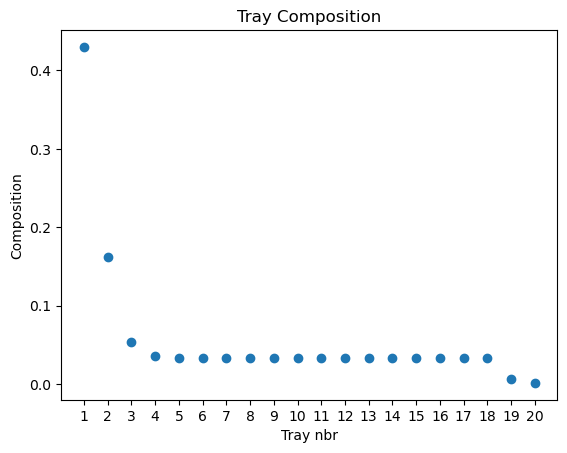

In [164]:

# destcol_actfact is a tray based model
# with activity factor model and equi-molar flows
# PARAMETERS
dd = {}
# *** equilibrium data
dd['P'] = 101300
# *** Flows:
# Feed
dd['F'] = 2268*0.9 # kmole/h
dd['xfeed'] = 0.144*1.1 # mole fraction

# Reflux ratio
dd['RD'] = 1.66
dd['V'] = 1027*1.1
dd['DD']= dd['V'] / (1+dd['RD']) 
#dd['BD']= dd['F'] - dd['DD']  # help to set the nominal flow

# *** Column
# Tray numbering
N = 20
dd['N'] = N
dd['Nf'] = 18
dd['Nr'] = dd['Nf']-1 # rectifier
dd['Ns'] = N-dd['Nf'] # stripper
# Tray hold-up
dd['M'] = 20 # kmole
dd['Mc'] = 500
dd['Mb'] = 200

xinit = dd['xfeed']*np.ones(N+2)
T0 = 273+80
Tinit = T0*np.ones(N+1)

L_F_init = np.ones(20)*1000
V_F_init = np.ones(20)*900

init = np.hstack((xinit, Tinit, L_F_init, V_F_init))
init = last_vals
Tspan = [0, 50]
n_ode = N+2 #22
n_ae = 3*N+1 #21
M11 = np.eye(n_ode) #(22,22)
M12 = np.zeros((n_ode,n_ae)) #(22,21)

#VSTACK(M11,M12) = (22,43)
M2_ = np.zeros((n_ae,n_ae+n_ode)) #(21,43)
MM = np.vstack(( np.hstack((M11,M12)),M2_ ))

#STEADY STATE
ss_sol=fsolve(lambda x: colmodel(0,x,dd),init)

xs = ss_sol[:N] 
xb = ss_sol[N] 
x0 = ss_sol[N+1] 
T = ss_sol[N+2:2*N+2] 
Tb = ss_sol[2*N+2] 
L = ss_sol[2*N+3:3*N+3] 
V = ss_sol[3*N+3:]
#print(f"L: {L}")
#print(f"V: {V}")
fig, ax = plt.subplots()
ax.plot(np.linspace(1,20,20),ss_sol[:20], 'o')
ax.set_xticks(range(1,21))
ax.set_title(f'Tray Composition')
ax.set_ylabel('Composition')
ax.set_xlabel('Tray nbr')

#WORKS: 1588.0559106336318, 582.7971747624092

#if not xs[10] == 0.144 and max(xs) < 1 and T[-1] < 400 and (T[-1]-[T0] > 10):
#    print(f"FRAME: {i}")
#    print(f"Liquid: {L_F_values[i]}")
#    print(f"Vapor: {V_F_values[i]}")
#    print(f"Temperatures: {T}")
#    print(f"Tb: {Tb}")
#    print(f"L: {L}")
#    print(f"V: {V}")
#    fig, ax = plt.subplots()
#    ax.plot(np.linspace(1,20,20),ss_sol[:20], 'o')
#    ax.set_title(f'Tray Composition frame: {i}')
#    ax.set_ylabel('Composition')
#    ax.set_xlabel('Tray nbr')
#    i += 1
#

init = np.hstack((xinit, Tinit, L_F_init, V_F_init))

Final Run Statistics: --- 

 Number of steps                                 : 797
 Number of function evaluations                  : 1004
 Number of Jacobian evaluations                  : 29
 Number of function eval. due to Jacobian eval.  : 1004
 Number of error test failures                   : 8
 Number of nonlinear iterations                  : 1004
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 50.0 seconds.
Elapsed simulation time: 1.7425653000027523 seconds.
DYN SOL::::::
(83, 1992)
LAST VALS: [7.51267821e-01 7.12824154e-01 6.67844215e-01 6.09945093e-01
 5.26889153e-01 3.95418840e-01 2.12370995e-01 9.26193081e-02
 5.80665994e-02 5.09334894e-02 4.95708096e-02 4.93143697e-02
 4.92662471e-02 4.92572214e-02 4.92555287e-02 4.92552113e-02
 4

Text(0.5, 1.0, 'Tray concentrations')

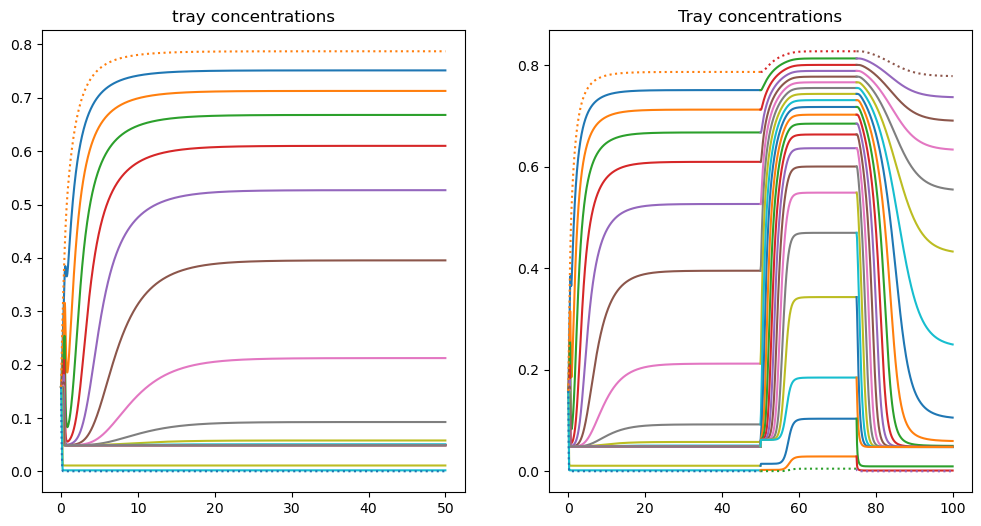

In [165]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
# Use solve_ivp_mass instead of solve_ivp in order to solve a dae
dyn = solve_ivp_mass(lambda t,x: colmodel(t,x,dd), Tspan, init, n=2000, mass=MM)

print(f"DYN SOL::::::")
print(dyn.y.shape)

last_vals = dyn.y[:,-1]
print(f"LAST VALS: {last_vals}")
dd['dyn'] = dyn
dd['ss'] = ss_sol
## plot of tray concentrations
ax[0].plot(dyn.t, dyn.y[:N,:].T)
ax[0].plot(dyn.t, dyn.y[N:N+2,:].T,':')
ax[0].set_title('tray concentrations')

Tspan2=[50, 75]
dd['xfeed']=1.1*dd['xfeed']

dyn2 = solve_ivp_mass(lambda t,x: colmodel(t,x,dd), Tspan2, dyn.y[:,-1], \
mass=MM)
dd['dyn2']=dyn2
Tspan3=[75, 100]
dd['F']=0.9*dd['F']
dyn3 = solve_ivp_mass(lambda t,x: colmodel(t,x,dd), Tspan3, dyn2.y[:,-1], \
mass=MM)
dd['dyn3']=dyn3
# Plot of tray concentrations

ax[1].plot(dyn.t,dyn.y[:N,:].T)
ax[1].plot(dyn.t,dyn.y[N:N+2,:].T,':')
ax[1].plot(dyn2.t,dyn2.y[:N,:].T)
ax[1].plot(dyn2.t,dyn2.y[N:N+2,:].T,':')
ax[1].plot(dyn3.t,dyn3.y[:N,:].T)
ax[1].plot(dyn3.t,dyn3.y[N:N+2,:].T,':')
ax[1].set_title('Tray concentrations')

Top comp: 0.787
Bottom comp: 0.000


Text(0.5, 1.0, 'Column profile')

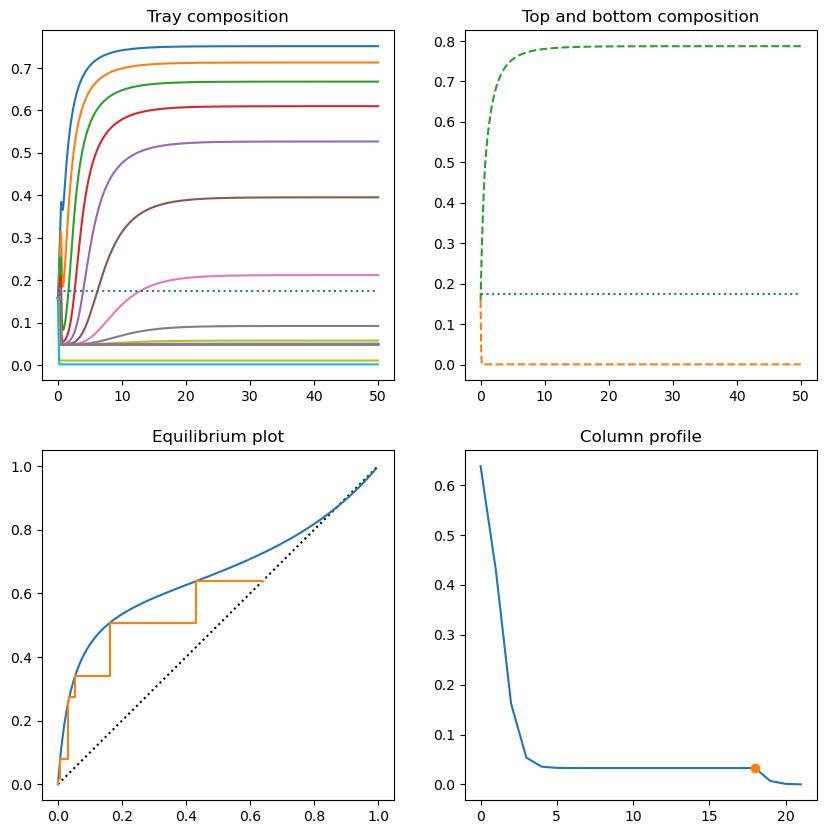

In [166]:
ss = dd['ss']
ss = ss_sol
dyn = dd['dyn']
N = dd['N']
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax = ax.ravel()
ax[0].plot(dyn.t,dyn.y[:N,:].T)
ax[0].plot([0,dyn.t[-1]], dd['xfeed']*np.ones(2), ':')
ax[0].set_title('Tray composition')

ax[1].plot([0, dyn.t[-1]], dd['xfeed']*np.ones(2), ':')
ax[1].plot(dyn.t, dyn.y[N:N+2,:].T,'--')
#ax[1].plot(dyn.t, dyn.y[N+1,:].T, '-k')
print(f"Top comp: {dyn.y[N+1,:].T[-1]:.3f}")
print(f"Bottom comp: {dyn.y[N,:].T[-1]:.3f}")
ax[1].set_title('Top and bottom composition')

xj = np.arange(0, 1, 0.01) # start,stop, step
Tguess = (273+80)*np.ones(len(xj))
yj, Tj = ActFactEquil(xj, Tguess, dd['P'])
xx = np.zeros(2*(N+1)+1)
xx[::2] = np.hstack( (ss[N+1], ss[:N], ss[N]) )
xx[1::2] = np.hstack( (ss[:N], ss[N] ) )
Tguess = (273+80)*np.ones(N+1)
ysol, Tsol = ActFactEquil(ss[:N+1], Tguess, dd['P'])
yy = np.zeros(2*(N+1)+1)
yy[::2] = np.hstack( (ysol[:N], ysol[N], ss[N]) )
yy[1::2] = np.hstack( (ysol[:N], ysol[N]) )
ax[2].plot([0, 1],[0, 1],':k')
ax[2].plot(xj, yj, xx, yy)
ax[2].set_title('Equilibrium plot')

ax[3].plot(np.arange(0,N+2), np.hstack((ss[N+1], ss[:N], ss[N])) )
ax[3].plot(dd['Nf'], ss[dd['Nf']-1], 'o')
ax[3].set_title('Column profile')
